# Carol Zhang

## Research Question/Interests

### Guest Experience & Satisfaction

Guest experience and satisfaction are crucial for Airbnb hosts since positive reviews can increase booking rates and listing visibility. Many travellers incorporate other guest reviews into their decision-making process when evaluating accommodation options. This research will explore key factors influencing guest satisfaction, such as pricing, host responsiveness, and amenities. By identifying patterns in high-rated listings, hosts can refine their offerings to improve guest experience and secure better reviews. 

### Key Research Questions
- How do listing features like the number of amenities or instant booking availability impact guest satisfaction ratings? 
- What is the relationship between the different ratings and the price of listings for different property types?
- Which amenities are most frequently associated with higher guest ratings in Airbnb listings?
- Do more descriptive listings have higher accuracy ratings? 

## EDA

#### Imports

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../../code"))

import altair as alt
import pandas as pd
import ast
from toolz.curried import pipe

# Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

from cleaning_workflows import prepare_dataset

#### Load in Data

In [2]:
df = pd.read_csv('../../data/raw/listings.csv', parse_dates=['first_review', 'last_review'])
# df = prepare_dataset(df)
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,39572,https://www.airbnb.com/rooms/39572,20250103033441,2025-01-03,city scrape,1 br in a 2 br apt (Midtown West),NaN,NaN,https://a0.muscache.com/pictures/fd1bffd9-ccf8...,169927,...,5.00,4.98,4.86,NaN,f,2,1,1,0,0.25
1,39593,https://www.airbnb.com/rooms/39593,20250103033441,2025-01-03,city scrape,A lovely room w/ a Manhattan view,"A private, furnished large room to rent Jan/F...","Nate Silver called this super safe, clean, qui...",https://a0.muscache.com/pictures/0b9110f7-3b24...,110506,...,4.96,4.79,4.93,NaN,f,1,0,1,0,0.20
2,39704,https://www.airbnb.com/rooms/39704,20250103033441,2025-01-03,previous scrape,"Private, Large & Sunny 1BR w/W&D",It's a No Brainer:<br />•Terrific Space For Le...,The Neighborhood<br />• Rich History <br />• B...,https://a0.muscache.com/pictures/0bc4e8a4-c047...,170510,...,4.92,4.38,4.72,NaN,f,2,2,0,0,1.93
3,42300,https://www.airbnb.com/rooms/42300,20250103033441,2025-01-03,city scrape,Beautiful Lower East Side Loft,Architect-owned loft is a corner unit in a bea...,"The apartment is in the border of Soho, LES an...",https://a0.muscache.com/pictures/0e285e13-ee14...,184755,...,4.87,4.57,4.62,NaN,f,1,1,0,0,0.40
4,42729,https://www.airbnb.com/rooms/42729,20250103033441,2025-01-03,city scrape,@HouseOnHenrySt - Private 2nd bedroom w/shared...,NaN,"Lovely old Brooklyn neighborhood, with brick/b...",https://a0.muscache.com/pictures/925fe213-f5e1...,11481,...,4.73,4.58,4.64,NaN,f,4,1,3,0,1.26


#### Data Cleaning

In [3]:
# Make a copy of the dataset
df_cleaned = df.copy()

In [4]:
# Drop unnecessary columns 
drop_columns = [
    'id',  # Unique identifier 
    'scrape_id',  # Only one unique value, provides no variation
    'last_scraped',  # Only one unique value, not useful for analysis
    'source',  # Only two unique values, not relevant for analysis
    'neighbourhood',  # No clear semantic meaning
    'calendar_updated',  # No clear semantic meaning, all values missing
    'license',  # Mostly missing values, not useful for analysis
    'host_name', # Not useful for analysis 
    'host_thumbnail_url',  # Just a link, not useful for analysis
    'host_picture_url',  # Just a link, not useful for analysis
    'host_url',  # Just a link, not useful for analysis
    'listing_url',  # Just a link, not useful for analysis
    'picture_url',  # Just a link, not useful for analysis
    'bathrooms_text',  # Redundant, `bathrooms` already provides numerical info
    'minimum_minimum_nights',  # Redundant, covered by `minimum_nights`
    'maximum_minimum_nights',  # Redundant, covered by `minimum_nights`
    'minimum_maximum_nights',  # Redundant, covered by `maximum_nights`
    'maximum_maximum_nights',  # Redundant, covered by `maximum_nights`
    'calendar_last_scraped'  # Similar to `last_scraped`, unnecessary
]

df_cleaned.drop(columns=drop_columns, inplace=True)

In [5]:
# Fill missing values for categorical variables
categorical_fill_values = {
    "name": "Unknown",
    "description": "No description available",
    "neighborhood_overview": "No overview available",
    "host_name": "Unknown",
    "host_location": "Not provided",
    "host_response_time": "No response time",
    "host_is_superhost": "f",
    "has_availability": "f",
    "instant_bookable": "f"
}

df_cleaned.fillna(value=categorical_fill_values, inplace=True)

In [6]:
# Convert date columns
date_cols = ["host_since", "first_review", "last_review"]
for col in date_cols:
    df_cleaned[col] = pd.to_datetime(df_cleaned[col], errors="coerce")
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

In [7]:
# Convert percentage columns to numeric
percentage_cols = ["host_response_rate", "host_acceptance_rate"]

for col in percentage_cols:
    df_cleaned[col] = df_cleaned[col].astype(str).str.replace("%", "").astype(float) / 100
    # Fill missing values with the median
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

In [8]:
# Convert the price column to string type, remove "$" and "," and convert to float
df_cleaned["price"] = df_cleaned["price"].astype(str)
df_cleaned["price"] = df_cleaned["price"].str.replace(r"[\$,]", "", regex=True).astype(float)

# Fill missing values with the median 
df_cleaned["price"] = df_cleaned["price"].fillna(df_cleaned["price"].median())

In [9]:
# Convert 't' and 'f' values to boolean (True/False) for binary columns
binary_columns = ['instant_bookable', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability']

for col in binary_columns:
    df_cleaned[col] = df_cleaned[col].map({'t': True, 'f': False})

In [10]:
# Fill missing numerical values with median
numerical_cols = df_cleaned.select_dtypes(include=["number"]).columns.tolist()
for col in numerical_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Fill missing values in categorical columns with the most common value
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
df_cleaned[categorical_cols] = df_cleaned[categorical_cols].fillna(df_cleaned[categorical_cols].mode().iloc[0])

# Strip leading/trailing spaces from string columns
df_cleaned[categorical_cols] = df_cleaned[categorical_cols].apply(lambda col: col.astype(str).str.strip())

C:\Users\Carol\AppData\Local\Temp\ipykernel_14012\3760752339.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned[categorical_cols] = df_cleaned[categorical_cols].fillna(df_cleaned[categorical_cols].mode().iloc[0])


In [11]:
df_cleaned.head()

,name,description,neighborhood_overview,host_id,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1 br in a 2 br apt (Midtown West),No description available,No overview available,169927,2010-07-17,"Saint-Aubin-sur-Scie, France","Facebook Likes:\r\nNew York French Geek, David...",within a day,1.00,0.88,...,4.98,5.00,4.98,4.86,False,2,1,1,0,0.25
1,A lovely room w/ a Manhattan view,"A private, furnished large room to rent Jan/F...","Nate Silver called this super safe, clean, qui...",110506,2010-04-18,"New York, NY","I grew up in South Korea, moved to Montreal, C...",within a few hours,1.00,0.60,...,4.96,4.96,4.79,4.93,False,1,0,1,0,0.20
2,"Private, Large & Sunny 1BR w/W&D",It's a No Brainer:<br />•Terrific Space For Le...,The Neighborhood<br />• Rich History <br />• B...,170510,2010-07-18,"New York, United States",I am a self employed licensed real estate brok...,No response time,1.00,0.88,...,4.89,4.92,4.38,4.72,False,2,2,0,0,1.93
3,Beautiful Lower East Side Loft,Architect-owned loft is a corner unit in a bea...,"The apartment is in the border of Soho, LES an...",184755,2010-07-29,"New York, NY",I am an architect living in NYC and have my ow...,within a day,1.00,1.00,...,4.85,4.87,4.57,4.62,False,1,1,0,0,0.40
4,@HouseOnHenrySt - Private 2nd bedroom w/shared...,No description available,"Lovely old Brooklyn neighborhood, with brick/b...",11481,2009-03-26,"New York, NY",I have been a host with Airbnb since its intro...,within a day,0.67,0.33,...,4.71,4.73,4.58,4.64,False,4,1,3,0,1.26


#### Summary Statistics 

In [12]:
df_cleaned.shape

(37784, 56)

In [13]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37784 entries, 0 to 37783
Data columns (total 56 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   name                                          37784 non-null  object        
 1   description                                   37784 non-null  object        
 2   neighborhood_overview                         37784 non-null  object        
 3   host_id                                       37784 non-null  int64         
 4   host_since                                    37784 non-null  datetime64[ns]
 5   host_location                                 37784 non-null  object        
 6   host_about                                    37784 non-null  object        
 7   host_response_time                            37784 non-null  object        
 8   host_response_rate                            37784 non-null  floa

In [14]:
df_cleaned.isnull().sum()

name                                            0
description                                     0
neighborhood_overview                           0
host_id                                         0
host_since                                      0
host_location                                   0
host_about                                      0
host_response_time                              0
host_response_rate                              0
host_acceptance_rate                            0
host_is_superhost                               0
host_neighbourhood                              0
host_listings_count                             0
host_total_listings_count                       0
host_verifications                              0
host_has_profile_pic                            0
host_identity_verified                          0
neighbourhood_cleansed                          0
neighbourhood_group_cleansed                    0
latitude                                        0


**Comments** 
- There are 377,784 observations and 56 columns after cleaning 
- There are no missing values in the dataset after imputation 

#### Feature Engineering

**`amenities`**
Currently, amenities are stored as a list of strings. In order 

In [15]:
# Extract and display the amenities column
amenities_column = df_cleaned['amenities']
print(amenities_column)

0        ["Hangers", "Wifi", "Smoke alarm", "Carbon mon...
1        ["Hangers", "Smoke alarm", "Hair dryer", "Clot...
2        ["Hangers", "Coffee maker", "Smoke alarm", "Fi...
3        ["Hangers", "Coffee maker", "Smoke alarm", "Ha...
4        ["Hangers", "Coffee maker", "Smoke alarm", "TV...
                               ...                        
37779    ["Hangers", "Smoke alarm", "Fire extinguisher"...
37780    ["Dedicated workspace", "HDTV with Amazon Prim...
37781    ["Hangers", "Smoke alarm", "Stove", "Cooking b...
37782    ["Wifi", "Central air conditioning", "Hot wate...
37783    ["Wifi", "TV", "Dedicated workspace", "Carbon ...
Name: amenities, Length: 37784, dtype: object


In [16]:
import ast

# Convert the string representation of lists back into actual lists
df_cleaned['amenities'] = df_cleaned['amenities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [20]:
# Flatten the list of amenities to count their frequencies
amenities_flat = [amenity for sublist in df_cleaned['amenities'] for amenity in sublist]

# Create a DataFrame of amenity counts
amenities_count = pd.Series(amenities_flat).value_counts().reset_index()
amenities_count.columns = ['amenity', 'count']

# Show the top amenities
amenities_count.head(25)

,amenity,count
0,Wifi,35169
1,Smoke alarm,34232
2,Kitchen,32889
3,Carbon monoxide alarm,29881
4,Essentials,28900
5,Heating,26301
6,Hangers,26254
7,Air conditioning,26158
8,Hot water,25006
9,Hair dryer,23183


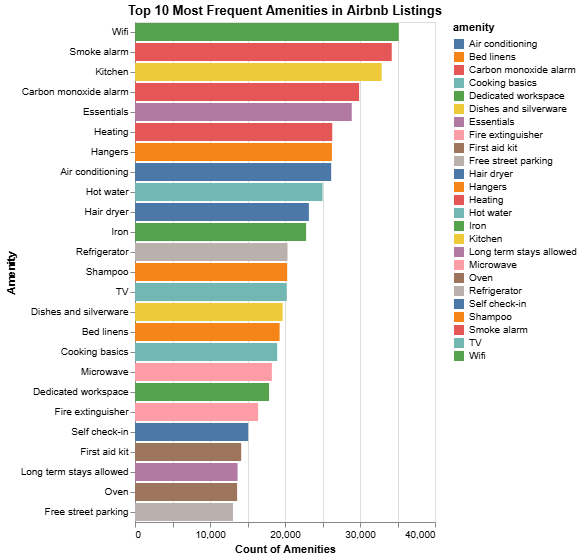

In [21]:
import altair as alt

# Create a bar chart to show the top amenities
chart = alt.Chart(amenities_count.head(25)).mark_bar().encode(
    x=alt.X('count:Q', title='Count of Amenities'),
    y=alt.Y('amenity:N', title='Amenity', sort='-x'),
    color='amenity:N'
).properties(
    title='Top 10 Most Frequent Amenities in Airbnb Listings'
)

chart.show()

In [27]:
# Calculate the frequency of each amenity
amenity_counts = df_cleaned['amenities'].explode().value_counts()

# Select the top 25 amenities by frequency
top_25_amenities = amenity_counts.head(25).index.tolist()

# Create the DataFrame for each amenity column (only for the top 25 amenities)
amenity_columns = pd.DataFrame(
    [[1 if amenity in x else 0 for amenity in top_25_amenities] for x in df_cleaned['amenities']],
    columns=top_25_amenities
)

# Concatenate the new amenity columns with the original DataFrame
df_cleaned = pd.concat([df_cleaned, amenity_columns], axis=1)
print(df_cleaned.columns)

Index(['name', 'description', 'neighborhood_overview', 'host_id', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate',
       ...
       'Bed linens', 'Cooking basics', 'Microwave', 'Dedicated workspace',
       'Fire extinguisher', 'Self check-in', 'First aid kit',
       'Long term stays allowed', 'Oven', 'Free street parking'],
      dtype='object', length=1745)


In [30]:
# Select only the relevant columns: amenity columns and 'review_scores_rating'
relevant_columns = top_25_amenities + ['review_scores_rating']

# Filter the DataFrame to include only these columns
df_relevant = df_cleaned[relevant_columns]

# Calculate the correlation matrix between the amenities and review_scores_rating
correlation_matrix = df_relevant.corr()

# Display the correlation matrix
correlation_matrix.head(10)

,Wifi,Wifi,Wifi,Smoke alarm,Smoke alarm,Smoke alarm,Kitchen,Kitchen,Kitchen,Carbon monoxide alarm,...,Long term stays allowed,Long term stays allowed,Long term stays allowed,Oven,Oven,Oven,Free street parking,Free street parking,Free street parking,review_scores_rating
Wifi,1.000000,1.000000,1.000000,0.029717,0.029717,0.029717,0.049441,0.049441,0.049441,0.009240,...,-0.080859,-0.080859,-0.080859,-0.002545,-0.002545,-0.002545,-0.093045,-0.093045,-0.093045,-0.017214
Wifi,1.000000,1.000000,1.000000,0.029717,0.029717,0.029717,0.049441,0.049441,0.049441,0.009240,...,-0.080859,-0.080859,-0.080859,-0.002545,-0.002545,-0.002545,-0.093045,-0.093045,-0.093045,-0.017214
Wifi,1.000000,1.000000,1.000000,0.029717,0.029717,0.029717,0.049441,0.049441,0.049441,0.009240,...,-0.080859,-0.080859,-0.080859,-0.002545,-0.002545,-0.002545,-0.093045,-0.093045,-0.093045,-0.017214
Smoke alarm,0.029717,0.029717,0.029717,1.000000,1.000000,1.000000,0.060987,0.060987,0.060987,0.565707,...,0.168611,0.168611,0.168611,0.147133,0.147133,0.147133,0.156467,0.156467,0.156467,0.028563
Smoke alarm,0.029717,0.029717,0.029717,1.000000,1.000000,1.000000,0.060987,0.060987,0.060987,0.565707,...,0.168611,0.168611,0.168611,0.147133,0.147133,0.147133,0.156467,0.156467,0.156467,0.028563
Smoke alarm,0.029717,0.029717,0.029717,1.000000,1.000000,1.000000,0.060987,0.060987,0.060987,0.565707,...,0.168611,0.168611,0.168611,0.147133,0.147133,0.147133,0.156467,0.156467,0.156467,0.028563
Kitchen,0.049441,0.049441,0.049441,0.060987,0.060987,0.060987,1.000000,1.000000,1.000000,0.023476,...,0.076672,0.076672,0.076672,0.208788,0.208788,0.208788,0.077915,0.077915,0.077915,0.045426
Kitchen,0.049441,0.049441,0.049441,0.060987,0.060987,0.060987,1.000000,1.000000,1.000000,0.023476,...,0.076672,0.076672,0.076672,0.208788,0.208788,0.208788,0.077915,0.077915,0.077915,0.045426
Kitchen,0.049441,0.049441,0.049441,0.060987,0.060987,0.060987,1.000000,1.000000,1.000000,0.023476,...,0.076672,0.076672,0.076672,0.208788,0.208788,0.208788,0.077915,0.077915,0.077915,0.045426
Carbon monoxide alarm,0.009240,0.009240,0.009240,0.565707,0.565707,0.565707,0.023476,0.023476,0.023476,1.000000,...,0.212343,0.212343,0.212343,0.182000,0.182000,0.182000,0.189580,0.189580,0.189580,0.015358


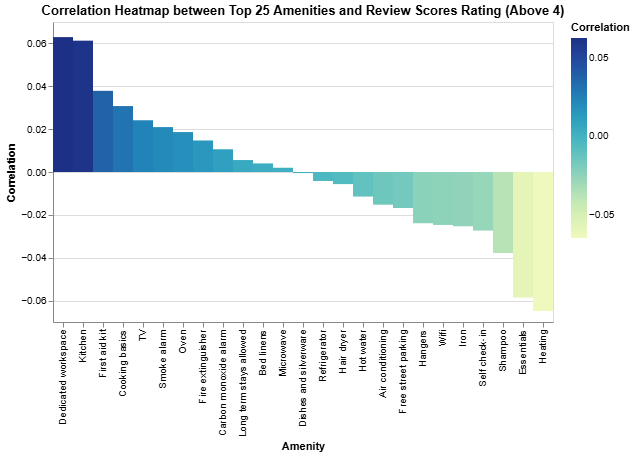

In [34]:
# Step 1: Filter the dataset for review_scores_rating > 4
df_filtered = df_cleaned[df_cleaned['review_scores_rating'] > 4]

# Step 2: Calculate the correlation matrix for the filtered dataset (for top amenities)
correlation_matrix_filtered = df_filtered[top_25_amenities].corrwith(df_filtered['review_scores_rating'])

# Step 3: Reshape the correlation data for Altair
correlation_long_filtered = correlation_matrix_filtered.reset_index()
correlation_long_filtered.columns = ['Amenity', 'Correlation']

# Step 4: Create a heatmap visualization using Altair
heatmap_filtered = alt.Chart(correlation_long_filtered).mark_rect().encode(
    x=alt.X('Amenity:N', sort='-y'),  # Sort by correlation value
    y='Correlation:Q',
    color='Correlation:Q',
    tooltip=['Amenity', 'Correlation']
).properties(
    title='Correlation Heatmap between Top 25 Amenities and Review Scores Rating (Above 4)'
)

# Display the chart
heatmap_filtered

#### Univariate Analysis

In [ ]:
# Quantitative Features
accidents.describe()

In [ ]:
# Nominal Features
accidents.describe(include=['object']) 

In [ ]:
# Histogram of Economic Loss to show distribution  
economic_loss_hist = alt.Chart(accidents).mark_bar().encode(
    alt.X('Economic Loss:Q', bin=alt.Bin(maxbins=10)),
    alt.Y('count()'),
).properties(
    title="Distribution of Economic Loss")

# Histogram of Medical Cost to show distribution 
medical_cost_hist = alt.Chart(accidents).mark_bar().encode(
    alt.X('Medical Cost:Q', bin=alt.Bin(maxbins=10)),
    alt.Y('count()')
).properties(
    title="Distribution of Medical Costs")

medical_cost_hist | economic_loss_hist

**Comments** 
- Economic Loss values range from 1,000.33 to 99,999.62, showing a large range. However, there is a balanced distribution of observations across all of the different bins. 
- Similarly, Medical Cost also has a wide range from 500.11 to 49,999.93 and a balanced distribution. 
- Data is collected from 10 countries, with Canada being the most frequent value 
- Nighttime accidents are the most frequent, so maybe visibility and fatigue are potential factors
- Binary variables like Driver Gender and Urban/Rural have roughly balanced numbers of both cases, so there likely isn't a large class imbalance

#### Multivariate Analysis

In [ ]:
# Bar chart of Accident Cause vs Economic Loss 
causes_barchart = alt.Chart(accidents).mark_bar().encode(
    alt.Y('Accident Cause:N', sort='-x'),
    alt.X('average(Economic Loss):Q', title="Average Economic Loss ($)", scale=alt.Scale(domain=[49000, 51000])),
    alt.Color('Accident Cause:N')
).properties(
    title="Average Economic Loss by Accident Cause", 
    height=300,
    width=400)

causes_zoomed = causes_barchart.encode(alt.X('average(Economic Loss):Q', title="Average Economic Loss ($)")
                                      ).properties(title="Average Economic Loss by Accident Cause [Zoomed In]")

causes_barchart  | causes_zoomed

From the bar charts above, it seems like Economic Loss doesn't vary much overall by Accident Cause and it isn't a good predictor for the cost of an accident. The difference between the cause with the highest average economic loss (Drunk Driving) and lowest (Speeding) is only $619.35.

In [ ]:
# Boxplot of how Medical Costs vary by Accident Severity 
boxplot_medical_costs = alt.Chart(accidents).mark_boxplot().encode(
    alt.X('Accident Severity:N', title='Accident Severity'),  
    alt.Y('Medical Cost:Q', title='Medical Cost ($)'),       
    alt.Color('Accident Severity:N', legend=None),       
    tooltip=['Accident Severity', 'Medical Cost']               
).properties(
    title="Medical Costs by Accident Severity", 
    height=400,  
    width=500)

boxplot_medical_costs

It doesn't look like Medical Costs vary by Accident Severity. All three levels of severity have near-identical distributions, max and min values, whiskers, and median values. 

In [ ]:
# Scatterplot of Medical Costs and Economic Loss
scatter_medical_economic = alt.Chart(accidents).mark_point().encode(
    alt.X('Medical Cost:Q'), 
    alt.Y('Economic Loss:Q'),     
    alt.Color('Accident Severity:N', legend=None),
    tooltip=['Medical Cost', 'Economic Loss', 'Accident Severity']
).properties(
    title="Medical Cost vs Economic Loss by Accident Severity",
    height=400,  
    width=500) 

scatter_medical_economic

There are no relationships in the scatterplot above. 

In [ ]:
# Heat map for columns related to Economic Loss and Medical Costs 

select_columns = ['Economic Loss', 'Medical Cost', 'Number of Vehicles Involved', 'Number of Fatalities', 'Insurance Claims']

corr_matrix = accidents[select_columns].corr()
corr_matrix_melted = corr_matrix.reset_index().melt(id_vars='index')
corr_matrix_melted.columns = ['Variable1', 'Variable2', 'Correlation']

heatmap = alt.Chart(corr_matrix_melted).mark_rect().encode(
    alt.X('Variable1:N', title='Variable 1'),
    alt.Y('Variable2:N', title='Variable 2'),
    alt.Color('Correlation:Q', scale=alt.Scale(scheme='viridis'), title='Correlation'),
    tooltip=['Variable1', 'Variable2', 'Correlation']
).properties(
    title="Correlation Heatmap",
    height=400,
    width=400)

heatmap

There are no correlations between the variables. 

### Task Analysis

#### Which accident-related factors contribute the most to economic loss, and how does their impact vary by accident severity?
- **Retrieve Value**: Extract Economic Loss, Accident Severity, and potential factors like Number of Vehicles Involved and Accident Cause.
- **Sort**: Sort Economic Loss from high to low to find highest contributing factors. 
- **Filter**: Filter accidents based on Accident Severity.
- **Compute Derived Value**: Calculate the average Economic Loss for categorical variables.
- **Correlate**: Analyze the relationship between Economic Loss and other variables.
- **Characterize Distribution**: Visualize how Economic Loss is distributed across different Accident Severity levels and other factors.
- **Determine Range**: Identify the range of Economic Loss for each Accident Severity level and assess how the range changes across different contributing factors.

#### How do medical costs and total economic loss per accident differ between urban and rural areas?
- **Retrieve Value**: Extract Medical Costs, Economic Loss, and Urban/Rural classifications.
- **Filter**: Filter accidents into Urban and Rural areas.
- **Correlate**: Analyze the relationship between Urban/Rural classification and Medical Costs or Economic Loss.
- **Cluster**: Group accidents based on Urban/Rural and other factors (like Accident Severity) to see if different areas show different patterns of cost.

#### Do speed limits impact the medical costs and economic loss associated with road accidents?
- **Retrieve Value**: Extract Speed Limits, Medical Costs, and Economic Loss for each accident.
- **Characterize Distribution**: Visualize the distribution of Economic Loss and Medical Costs for different Speed Limits.
- **Correlate**: Analyze the relationship between Speed Limit and Medical Costs or Economic Loss, identifying if higher speed limits are correlated with higher costs.